<a href="https://colab.research.google.com/github/BlancaCC/Computer-vision/blob/main/P3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 3 
Autor: Blanca Cano Camarero 




# Apartado 1: BaseNet en CIFAR1000

Convolucional, es decir, Conv2D.(normal y atrous)
Agrupación: Local y Global MaxPooling2D and AveragePooling2D().
Densa (lineal), es decir, Fully connected
Activaciones no lineales, p.e. relu, leaky relu, etc
Aplanar, es decir, Flatten.
Normalización del batch, p.e. BatchNormalization.
Regularización: p.e. Dropout



Comprobamos que el tamaño de test y entrenamiento son los pedidos en el enunciado: 
Shape de entrenamiento:  (12500, 25) Shape de test:  (2500, 25)


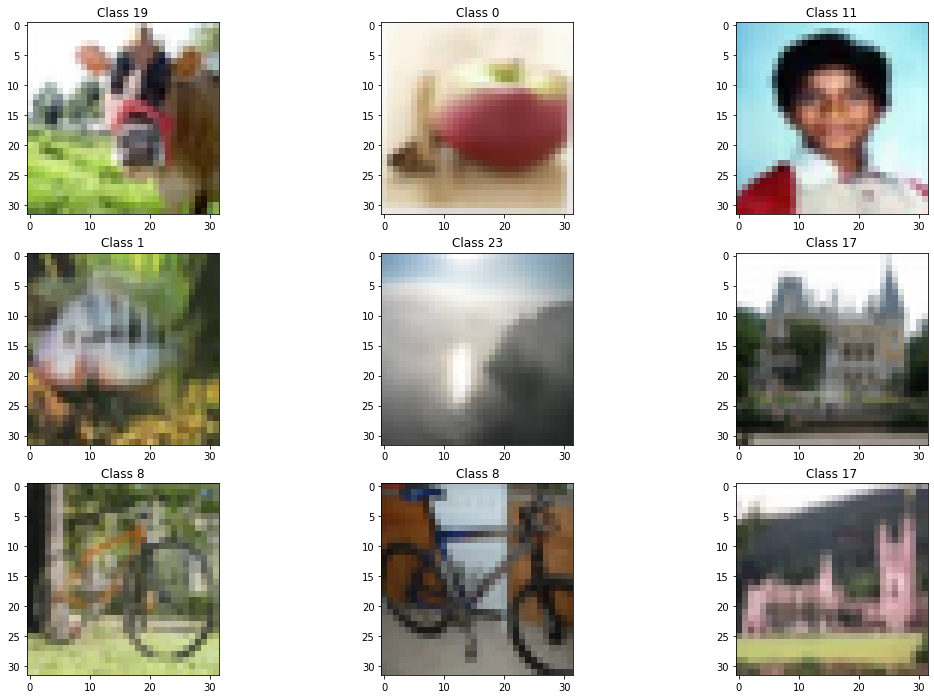

In [7]:
#Importamos los paquetes necesarios para toda la práctica
import tensorflow
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D, Input, Dense, MaxPooling2D, Flatten, UpSampling2D
# Importar el optimizador a usar
from tensorflow.python.keras.optimizers import *
# Importar el conjunto de datos
from keras.datasets import cifar100
from keras.preprocessing.image import ImageDataGenerator

# Importar el optimizador a usar
# TODO comentar https://keras.io/api/optimizers/sgd/
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

######### variables globales  
num_classes = 25

# A partir de aquí has el final de la celda seguimos el esquema de la parte 1 y 2

#########################################################################
######## FUNCIÓN PARA CARGAR Y MODIFICAR EL CONJUNTO DE DATOS ###########
#########################################################################

# A esta función sólo se le llama una vez. Devuelve 4 vectores conteniendo,
# por este orden, las imágenes de entrenamiento, las clases de las imágenes
# de entrenamiento, las imágenes del conjunto de test y las clases del
# conjunto de test.

def cargarImagenes():
  # Cargamos Cifar100. Cada imagen tiene tamaño (32, 32, 3).
  # Nos vamos a quedar con las imágenes de 25 de las clases.
  
  (x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')
  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')
  x_train /= 255
  x_test /= 255
  
  train_idx = np.isin(y_train, np.arange(num_classes))
  train_idx = np.reshape(train_idx,-1)
  x_train = x_train[train_idx]
  y_train = y_train[train_idx]
  
  test_idx = np.isin(y_test, np.arange(num_classes))
  test_idx = np.reshape(test_idx, -1)
  x_test = x_test[test_idx]
  y_test = y_test[test_idx]
  
  # Transformamos los vectores de clases en matrices. Cada componente se convierte en un vector
  # de ceros con un uno en la componente correspondiente a la clase a la que pertenece la imagen.
  # Este paso es necesario para la clasificación multiclase en keras.
  y_train = np_utils.to_categorical(y_train, 25)
  y_test = np_utils.to_categorical(y_test, 25)
  
  return x_train, y_train, x_test, y_test

#########################################################################
######## FUNCIÓN PARA OBTENER EL ACCURACY DEL CONJUNTO DE TEST ##########
#########################################################################

# Esta función devuelve el accuracy de un modelo, definido como el 
# porcentaje de etiquetas bien predichas frente al total de etiquetas.
# Como parámetros es necesario pasarle el vector de etiquetas verdaderas
# y el vector de etiquetas predichas, en el formato de keras (matrices
# donde cada etiqueta ocupa una fila, con un 1 en la posición de la clase
# a la que pertenece y 0 en las demás).

def calcularAccuracy(labels, preds):
  labels = np.argmax(labels, axis = 1)
  preds = np.argmax(preds, axis = 1)
  
  accuracy = sum(labels == preds)/len(labels)
  
  return accuracy



#########################################################################
## FUNCIÓN PARA PINTAR LA PÉRDIDA Y EL ACCURACY EN TRAIN Y VALIDACIÓN ###
#########################################################################

# Esta función pinta dos gráficas, una con la evolución de la función
# de pérdida en el conjunto de train y en el de validación, y otra
# con la evolución del accuracy en el conjunto de train y en el de
# validación. Es necesario pasarle como parámetro el historial
# del entrenamiento del modelo (lo que devuelven las funciones
# fit() y fit_generator()).

def mostrarEvolucion(hist):
  '''Historial contiene un diccionario, donde para un entrenamientod de dos épocas prodría ser de la forma: 
  'accuracy': [0.3411555588245392, 0.3743111193180084],
 'loss': [2.2396469116210938, 2.114685535430908],
 'val_accuracy': [0.3456000089645386, 0.376800000667572],
 'val_loss': [2.209703207015991, 2.1312973499298096]}
  '''

  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  plt.plot(loss)
  plt.plot(val_loss)
  plt.legend(['Training loss', 'Validation loss'])
  plt.show()
  

  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  plt.plot(acc)
  plt.plot(val_acc)
  plt.legend(['Training accuracy', 'Validation accuracy'])
  plt.show()
  
# Cargamos imágenes y vemos su tamaño   
x_train, y_train, x_test, y_test =  cargarImagenes()
print('Comprobamos que el tamaño de test y entrenamiento son los pedidos en el enunciado: ')
print('Shape de entrenamiento: ', y_train.shape, 'Shape de test: ', y_test.shape)

#VISUALIZAMOS ALGUNAS DE LAS IMÁGENES DEL DATASET
number_images_per_row = 3
result = np.where(y_train == 1)
fig = plt.figure()
for i in range(number_images_per_row*number_images_per_row):
  label = 'Class {}'.format(result[1][i])
  plt.subplot(number_images_per_row,number_images_per_row,i+1).set_title(label)
  plt.imshow(x_train[i].squeeze(), cmap='gray',vmin=0,vmax=1)

fig.set_size_inches(np.array(fig.get_size_inches()) * number_images_per_row)
plt.show()



# Ejercicio 1 
## Definición del modelo BASENET
Para este ejercicio trabajaremos con el modelo BaseNet que consta de dos módulos convolucionales, la descripción precisa es la siguiente: 


|Layer | Layer type | tamaño kernel | input / output dim | input/output channels |
|:-: | :-: | :-:  | :-:  | :-: |
|1 | conv2d  | 5 | 32/28 | 3 / 6 | 
|2 | Relu  |  | 28/28 |   |  
|3 | MaxPooling2D | 2 | 28 / 14 | |  
|4 | conv2d  | 5 | 14/10 | 6 / 16 | 
|5 | Relu  |  | 10/10 |   |  
|6 | MaxPooling2D | 2 | 10 / 5 | |
|7 | Linear |  | 400/50 |   |  
|8 | Relu  |  | 50/50 |   |  
|9 | Lineal  |  | 50/25 |   |   


  

## Descripción teórica y de uso en keras de cada capa    

### Clase `Sequential`  

Documentación:  

- Documentación oficial de keras consultada a día 18-12-2021: https://keras.io/api/models/sequential/  

Necesitaremos primero definir una clase `Sequential` en la que poder alamcenar la cola de capas que se deberán de ir aplicando. 

`tf.keras.Sequential(layers=None, name=None)`  

### Convolución 2D  

Documentación: 
- Documentación oficial de keras consultada a día 18-12-2021: https://keras.io/api/layers/convolution_layers/convolution2d/  

Descripcion:  
Esta capa crea un kernel de convolución que se aplica a la capa de entrada produciendo un tensor de salida.    

Los argumentos soportados por keras son los siguientes: 

```python
tf.keras.layers.Conv2D(
    filters,
    kernel_size,
    strides=(1, 1),
    padding="valid",
    data_format=None,
    dilation_rate=(1, 1),
    groups=1,
    activation=None,
    use_bias=True, 
    kernel_initializer="glorot_uniform",
    bias_initializer="zeros",
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
    **kwargs
)

```

Parámetros a tener en cuenta: 
- `filters`: Valor entero que indica la dimensionalidad de salidad (el valor a la derecha de la última columna de la tabla), este en verdad indica el número de filtros que aplicarle.  

- Si `use_bias = True` un vector de sesgo es añadido, como en nuestro caso no se especifica nada lo dejaremos en blanco.  
- Puede añadirse una función de activación que se aplicará a la salida gracias a `activation`. 

- Si es la primera capa en el modelo debe inicializarse `input_shape` con una tupla que recoja los tamaños siempre que ésta no tenga la variable `size` (como es nuestro caso).   

- `data_format` será el parámetro que convenga si la dimensión de los canales va al principio o al final, los parámetros que admite son los strings: `'channels_first'` o `'channels_last'`. Puede consultase y modificar con: `tf.keras.backend.image_data_format()`.  **En nuestro caso usaremos convenio `channels_last`* por seguir la notación de teoría.**

Por lo que nuestro input channel será del tipo `channels_last` y concretamente `(32,32,3)` ya que las imágenes son de tamaño 32x32 y además están a color. 

Comentaremos el significado de más parámetros conforme los vayamos necesitando. 

## Relu    

Documentación a día 18-12-21: https://keras.io/api/layers/activations/   

Cuando se hace referencia a relu se refiere a que se aplique tal función de activación a la salida. Esto puede hacerse equivalentemente de dos maneras:  

1. Si aparece después de una capa de Conv2D, en la función de queras que implementa la convolución añadir el arguemento `activation=relu`.   

2. Añadiendo la capa ` Activation("relu")` directamente al modelo.   

Durante nuestra implementación obtaremos por el primer método. 

### En qué consiste tal función de activación  

Como se ha visto en teoría una función de activación es una función que se encarga de transformar al salida,  en el lcaso de una relu esta es de la forma $f(x) = max(0, x)$ 

La mayor ventaja que aporta esta función es su bajo coste computacional. 

## Maxpooling   

Documentanción: 
Página oficial de keras: Maxpooling 2d, consultada a día 18-12-21
https://keras.io/api/layers/pooling_layers/max_pooling2d/  

Como se ha visto en teoría consiste en la reducción de dimensionalidad del input. 

Para su implementación utilizaremos la función `MaxPooling2D` de keras que admite los siguientes parámetros: 

```python
tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2), strides=None, padding="valid", data_format=None, **kwargs
)

```    


## Flatten    

Documentación oficial de keras sobre *flatten layer*, consultada a día 18-12-21: https://keras.io/api/layers/reshaping_layers/flatten/  

Esta capa no se especifica en la arquitectura pero es necesara añadirla antes de la capa 7. 

Nos permitirá transformar un input de  $5 \times 5 \times 16$ a 400, es decir transformará la entrada a un vector 1D. 

A partir de aquí comienza la capa densamente conectada.   


### Consideraciones sobre los parámetros  

Sobre `padding`, según se indica en la documentación oficial puede tomar dos valores posibles:  

- `padding = "valid"` en este caso no se aplica ningún padding (ie padding = 0).  Por lo que la salida vendría dada por `output_shape = math.floor((input_shape - pool_size) / strides) + 1 (when input_shape >= pool_size)`. 

- `padding = "same"` se intenta añadir un padding de ceros equilibrado en los extremos de manera que la entrada tenga el mismo tamaño que la salida.   

En nuestro caso se utilizará siempre `padding = "valid"` por los requisitos de input out que se nos piden. 

## Softmax

Documentación:
- Oficial de keras sobre *softmax*, consultada a día 18-12-21:
https://keras.io/api/layers/activation_layers/softmax/  
-   Bridle, J.S. (1990a). Probabilistic Interpretation of Feedforward
   Classification Network Outputs, with Relationships to Statistical Pattern
   Recognition. In: F.Fogleman Soulie and J.Herault (eds.), Neurocomputing:
   Algorithms, Architectures and Applications, Berlin: Springer-Verlag, pp.
   227-236.   

Hace referencia a la función de activación. Aunque no se especifica explícitamentente en la tabla de la arquitectura es necesario añadirla ya que se está afrontando un problema de clasificación. Esto se debe a que la función *softmax* es una generalización de la función exponencial y que en teoría de la probabilidad sirve para representar una distribución de probabilidad sobre $k$ posibles salidas. 

Se puede definir de la siguiente manera: 

$\sigma: \mathbb {R}^K \longrightarrow [0,1]^ K$

$$\sigma (x)_j = \frac{e^{x_j}}{\sum_{k=1}^K e^{x_k}}$$ 

para cada componente j ésima del vector $x$.


## Observaciones  sobre la tabla que representa la arquitectura.  

1. No se precisa información como el tamaño de stride o padding en ciertas capas que permiten tal configuraciones; como lo son  las de convolución 2D o MaxPooling2D. Es por ello que se tomarán los valores por defecto (cero de padding y 1 de stride). 

Las tablas indicadoras muestran información redundante ya que en las distintas capas la siguiente información es equivalente: 

- En **convolución**: Conocer el tamaño de kernel ($K$) y la salida ($w_o$) entrada($w_i$) ya  que vienen dadas por $w_o = ( w_i - K +2P)/S +1$  con $S=1$ el stride y $P=0$ el padding. 
- Dimensión de entrada o salida de una **capa relu o linear**, ya que no las modifica. 
- En **maxPooling** el tamaño del kernel y la salida y entrada.   

3. Las celdas de la tabla vacía son coherentes con la teoría. 
x


# A completar
# 1.- Incluir  import del tipo de modelo y capas a usar
# 2.- definir model e incluir las capas en él

In [2]:
# necesario introducir el tamaño inicial 
# Calculamos input shape 
# las imágenes son de 32x32x3 según la documentación de prácticas, luego 
input_shape = (32,32,3) 

# Descripción del modelo 
model = Sequential(name='Ejercicio_1')
# capa 1 y 2 
model.add(Conv2D( filters= 6, # parámetro de output channels  
                 kernel_size=(5, 5),
                 activation='relu', # capa 2 función activación
                 input_shape=input_shape) # parámetro necesario por tratarse de la priemera capa
) 
# capa 3 Maxpooling2D 2x2
model.add(MaxPooling2D(pool_size=(2, 2), 
                       padding="valid") # queremos que se reduzca dimensionalidad
)
# Capa 4 y 5 
model.add(Conv2D( filters= 16, # parámetro de output channels  
                 kernel_size=(5, 5),
                 activation='relu', # capa 5 función activación
                 input_shape=input_shape) # parámetro necesario por tratarse de la priemera capa
) 
# Capa 6 Maxpooling2D 2x2
model.add(MaxPooling2D(pool_size=(2, 2), 
                       padding="valid") # queremos que se reduzca dimensionalidad
)
# Capa 7
model.add( Flatten() )
model.add( Dense(units = 50, activation='linear') )
# Capa 8 
model.add(Dense(units = 50, activation='relu'))
# Capa 9 
model.add( Dense(units = 25, activation='linear') )
# Capa final de clasificación
model.add(Dense(num_classes, activation='softmax'))

print('Impirimos tabla resumen ')
model.summary()

Impirimos tabla resumen 
Model: "Ejercicio_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         456       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (

TODO: Es necesario  la última capa introducida  

# Apartado segundo del ejercicio primero
Una vez definido el modelo, proseguiremos con su entrenamiento, cálculo de *accuracy* y función de  pérdida para el conjunto de test.  

## Entrenamiento  

Para el entrenamiento de una red neuronal es necesario definir: 
1. Optimizador con el que minimizar el error. 
2. Tamaño de batch. 
3. Número de épocas.
4. Validación, porcentaje y método.   

### Optimizador 

Bibliografía:   

- [1] Oficial de keras sobre *optimizers* consultada a día 19-12-21: https://keras.io/api/optimizers/  

- [2] Artículo: *Comparative Study of First Order Optimizers for
Image Classification Using Convolutional Neural
Networks on Histopathology Images* de autores *Ibrahem Kandel, Mauro Castelli and Aleš Popoviˇ* Publicado el 8 de septiembre de 2020. DOI:  https://doi.org/10.3390/jimaging6090092  

- [3] Saleem MH, Potgieter J, Arif KM. Plant Disease Classification: A Comparative Evaluation of Convolutional Neural Networks and Deep Learning Optimizers. Plants (Basel). 2020 Oct 6;9(10):1319. doi: 10.3390/plants9101319. PMID: 33036220; PMCID: PMC7599959.

- [4] Yaqub M,Jinchao F, Zia M. State-of-the-Art CNN Optimizer for Brain Tumor Segmentation in Magnetic Resonance Images. Brain Sci. 2020 Jul 3;10(7):427. doi: 10.3390/brainsci10070427.

- [5] Oficial de keras sobre el optimizador Adam, consultado a días 19-12-21: https://keras.io/api/optimizers/adam/

Los contenido en la biblioteca de keras son los siguientes [1]: 

- SGD
- RMSprop
- Adam
- Adadelta
- Adagrad
- Adamax
- Nadam
- Ftrl  

Tras indagar cuál podría ser mejor candidato parece ser que los optimizadores adaptativos (salvo AdaGrad) resultan mejores. [2]  Además el de Adam es que el mejores resultados da [3] [4] [5]. 

Nos basaremos pues en el optimizador Adam [5], siendo conscientes de que estos artículos solo son una indicación ya que ninguno nos dice que Adam es mejor para nuestro problema particular de clasificación. 

Los argumentos que recive este optimizados son: 

```python 
tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam",
    **kwargs
)
```  

Como para este ejercicio no se pide optimizar el modelo, solo entrenarlo, lo dejaremos con los valores por defecto y en apartados posteriores trataremos el ajuste de los mismos.  

### Tamaño de batch  

Para esta primera aproximación utilizaremos un valor apriori de 32 ya que como vimos en aprendizaje automático era una buena heurística. 

### Validación 

En el guión de prácticas se pide un porcentaje de validación del 10%, que además nos parece un valor razonable por el tamaño de entrenamiento. Será pues éste el que utilicemos.   

Por tratarse de un problema de clasificación



## API modelo de entrenamiento   

Documentación: 

- [6] Documentación oficial de keras sobre *Model training APIs*, consultada el 19-12-21: https://keras.io/api/models/model_training_apis/

- [7] Documentación oficial de keras sobre *Losses*, consultada el 19-12-21: https://keras.io/api/losses/  

- [8] Documentación oficial de keras sobre *CategoricalCrossentropy class*, consultada el 19-12-21: https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class

Una vez seleccionado el optimizador es neceario configurar los parámetros para su entrenamiento. 

Los argumentso que admiten son [6]: 

```python
Model.compile(
    optimizer="rmsprop",
    loss=None,
    metrics=None,
    loss_weights=None,
    weighted_metrics=None,
    run_eagerly=None,
    steps_per_execution=None,
    **kwargs
) 
```  

### Loss  


Hace referencia a la función de pérdida, durante el entrenamiento se busca minimizar su error. [7]   

Existen distintos tipos: 
- Probabilístico. 
- De regresión.
- *Hinge losse*.

Por el ámbito  del problema utilizaremso los probabilísticos. 


Para los cuales están disponible (aunque es posible usar uno propio): 

- BinaryCrossentropy class
- CategoricalCrossentropy class
- SparseCategoricalCrossentropy class
- Poisson class
- binary_crossentropy function
- categorical_crossentropy function
- sparse_categorical_crossentropy function
- poisson function
- KLDivergence class
- kl_divergence function


Vamos a seleccionar *CategoricalCrossentropy* [8] ya que además es utilizada para problemas de clasificación y fue la indicada en teoría. 

Los argumentos que admite son [8]: 

```python
tf.keras.losses.CategoricalCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction="auto",
    name="categorical_crossentropy",
)
```

TODO: continual descripción más adelante. https://keras.io/api/models/model_training_apis/ de los parámetros a ajustar. 
--- 
TODO hablar de las funciones
TODO hablar del accuracy qué significa


Epoch 1/15
352/352 [==============================] - 11s 29ms/step - loss: 1.6263 - accuracy: 0.5044 - val_loss: 1.9553 - val_accuracy: 0.4368
Epoch 2/15
352/352 [==============================] - 10s 28ms/step - loss: 1.5925 - accuracy: 0.5154 - val_loss: 1.9353 - val_accuracy: 0.4568
Epoch 3/15
352/352 [==============================] - 10s 28ms/step - loss: 1.5532 - accuracy: 0.5280 - val_loss: 1.9230 - val_accuracy: 0.4400
Epoch 4/15
352/352 [==============================] - 10s 29ms/step - loss: 1.5131 - accuracy: 0.5379 - val_loss: 1.9470 - val_accuracy: 0.4416
Epoch 5/15
352/352 [==============================] - 10s 28ms/step - loss: 1.4871 - accuracy: 0.5433 - val_loss: 1.9261 - val_accuracy: 0.4672
Epoch 6/15
352/352 [==============================] - 10s 29ms/step - loss: 1.4480 - accuracy: 0.5539 - val_loss: 1.9289 - val_accuracy: 0.4472
Epoch 7/15
352/352 [==============================] - 10s 28ms/step - loss: 1.4160 - accuracy: 0.5660 - val_loss: 2.0586 - val_accuracy:

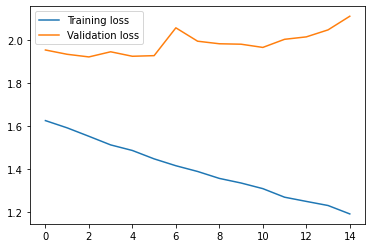

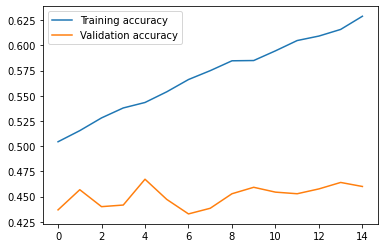

79/79 [==============================] - 1s 13ms/step
Accuracy en el conjunto test: 0.4592


In [9]:
#########################################################################
#########           Variables globales necesarias               ######### 
#########################################################################

# valor por defecto para batch_size en keras al hacer
tam_batch = 32
# porcentaje de entrenamiento que utilizará como validación
porcentaje_validacion = 0.1
# número de epocas a entrenar el modelo
epocas = 15


#########################################################################
######### DEFINICIÓN DEL OPTIMIZADOR Y COMPILACIÓN DEL MODELO ###########
#########################################################################

# incluir model.compile()
optimizador = Adam() 

# es multiclase, luego usamos categorical_crossentropy como perdida
# TODO explicar
model.compile( loss = keras.losses.categorical_crossentropy,
              optimizer = optimizador,
              metrics = ["accuracy"] )


# Una vez tenemos el modelo base, y antes de entrenar, vamos a guardar los 
# pesos aleatorios con los que empieza la red, para poder reestablecerlos 
# después y comparar resultados entre no usar mejoras y sí usarlas.
weights = model.get_weights() # TODO explicar

#########################################################################
###################### ENTRENAMIENTO DEL MODELO #########################
#########################################################################

# Incluir model.fit()
# TODO explicar
evolucion_entrenamiento = model.fit(
    x_train, y_train, 
    batch_size = tam_batch,
     epochs = epocas, 
     validation_split = porcentaje_validacion,
      verbose = 1)
# Incluir función que muestre la evolución del entrenamiento y validación
mostrarEvolucion(evolucion_entrenamiento)

#########################################################################
################ PREDICCIÓN SOBRE EL CONJUNTO DE TEST ###################
#########################################################################

# TODO explicar

#Incluir model.eva.luate() 
prediccion = model.predict(x_test, batch_size = tam_batch, verbose = 1)
#Incluir función que muestre la perdida y accuracy del test
precision_test = calcularAccuracy(y_test, prediccion)
print("Accuracy en el conjunto test: {}".format(precision_test))

## Resultados del modelo

Accuracy en el conjunto test: 0.4592  

El modelo ha sido sobreentranado, con 7 épocas hubiera sido suficiente. 

Ya que como se ve el error en entrenamiento y validación decae hasta la época 7. Sin embargo a partir de aquí el de validación empieza a ascender aunque se sigue disminuyendo el de entramiento. Síntoma evidente de sobrentrenamiento.  

Por otra parte el accuracy es bastante mediocre, ya que como vimos en clase este porcentaje era incluso alcanzable sin el uso de redes neuronales. 